In [1]:
import pandas as pd
from scipy.sparse import csr_matrix
import numpy as np
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import process
import matplotlib.pyplot as plt
import matplotlib as mpl
from numpy import count_nonzero


C:\Users\steph\anaconda3\envs\dev\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## Importing CSV Files

In [2]:
# Reading in csv files
df_books = pd.read_csv("Books.csv", low_memory=False)
df_books = df_books.drop(['Image-URL-S','Image-URL-L'],axis=1)
df_ratings = pd.read_csv("Ratings.csv", dtype={'User-ID':'int32','ISBN':'str','Book-Rating':'int32'}, low_memory=False)

In [3]:
df_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-M
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...


In [4]:
df_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-M          271360 non-null  object
dtypes: object(6)
memory usage: 12.4+ MB


In [5]:
df_books.nunique()

ISBN                   271360
Book-Title             242135
Book-Author            102022
Year-Of-Publication       118
Publisher               16807
Image-URL-M            271044
dtype: int64

In [6]:
df_ratings.dtypes

User-ID         int32
ISBN           object
Book-Rating     int32
dtype: object

In [7]:
df_ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [8]:
# For books with rating of 0, assume the book was not rated by the user.  Change the Rating to NaN.

df_ratings.replace(0, np.nan, inplace=True)
df_ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,NaN
1,276726,0155061224,5.0
2,276727,0446520802,NaN
3,276729,052165615X,3.0
4,276729,0521795028,6.0


## Merging Ratings and Books DataFrames
Merge so every row has a User-ID and Book Title

In [9]:
# Merging the Ratings dataframe with the books dataframe.  
# Only keep rows that have a book title with the corresponding ISBN from the ratings table

df_ratings_books = df_ratings.merge(df_books, on='ISBN', how='inner')
df_ratings_books.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-M
0,276725,034545104X,NaN,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...
1,2313,034545104X,5.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...
2,6543,034545104X,NaN,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...
3,8680,034545104X,5.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...
4,10314,034545104X,9.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...


In [10]:
df_ratings_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031136 entries, 0 to 1031135
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   User-ID              1031136 non-null  int32  
 1   ISBN                 1031136 non-null  object 
 2   Book-Rating          383842 non-null   float64
 3   Book-Title           1031136 non-null  object 
 4   Book-Author          1031134 non-null  object 
 5   Year-Of-Publication  1031136 non-null  object 
 6   Publisher            1031134 non-null  object 
 7   Image-URL-M          1031136 non-null  object 
dtypes: float64(1), int32(1), object(6)
memory usage: 59.0+ MB


# Data Exploration
Visualizations for an overview of merged ratings and books datasets.

### Combining Information for Books with Variations on Book-Titles

In [11]:
# Editing title text for Book in figure
df_ratings_books = df_ratings_books.replace("Angels &amp; Demons", 'Angels & Demons')
df_ratings_books = df_ratings_books.replace("J. R. R. Tolkien", 'J.R.R. Tolkien')

In [12]:
# Defining a function that returns a list of Book-Title variations on a base book-title name
def book_title_fix(dataframe, booktitle):
    nameversions = df_ratings_books[df_ratings_books['Book-Title'].str.contains(booktitle)]
    grouped = nameversions.groupby("Book-Title").nunique().reset_index(drop=False)
    global nameversionlist
    nameversionlist = grouped['Book-Title'].tolist()
    print(dataframe[dataframe['Book-Title'].str.contains(booktitle)].groupby('Book-Title').count()['User-ID'])
    for name in nameversionlist:
        print(df_ratings_books.loc[df_ratings_books['Book-Title'] == name, :]['Book-Author'].unique())

In [13]:
# Defining a function that re-names Book-Titles based on output from f(book_title_fix)
# 
def removefromname(dataframe, booktitle, nameversionlist, removelist):
    for word in removelist:
        nameversionlist = [name for name in nameversionlist if word not in name]
    global reduced
    reduced = nameversionlist
    for title in reduced:
        dataframe = dataframe.replace(title, booktitle)
    print('Book-Titles reduced to:')
    print(dataframe[dataframe['Book-Title'].str.contains(booktitle)].groupby('Book-Title').count()['User-ID'])
    return dataframe

In [14]:
# Finding Top 50 books by book-title -- 
# Book-title list used to query if book has mulitple variations of Book-Title name.
# Allow of aggregation of Book-Title variations for more efficient data exploration

book_sort = df_ratings_books.groupby("Book-Title").count().sort_values("User-ID", ascending=False)
book_sort = book_sort[0:50]
book_sort

,User-ID,ISBN,Book-Rating,Book-Author,Year-Of-Publication,Publisher,Image-URL-M
Book-Title,,,,,,,
Wild Animus,2502,2502,581,2502,2502,2502,2502
The Lovely Bones: A Novel,1295,1295,707,1295,1295,1295,1295
The Da Vinci Code,898,898,494,898,898,898,898
A Painted House,838,838,366,838,838,838,838
The Nanny Diaries: A Novel,828,828,393,828,828,828,828
Bridget Jones's Diary,815,815,377,815,815,815,815
The Secret Life of Bees,774,774,406,774,774,774,774
Divine Secrets of the Ya-Ya Sisterhood: A Novel,740,740,323,740,740,740,740
The Red Tent (Bestselling Backlist),723,723,383,723,723,723,723


In [15]:
title = "Wild Animus"
book_title_fix(df_ratings_books, title)

Book-Title
Wild Animus    2502
Name: User-ID, dtype: int64
['Rich Shapero']


In [16]:
title = "The Red Tent"
book_title_fix(df_ratings_books, title)

Book-Title
The Red Tent                                                      3
The Red Tent (Bestselling Backlist)                             723
The Red Tent (Wheeler Large Print Press (large print paper))      1
The Red Tent : A Novel                                           29
Name: User-ID, dtype: int64
['Anita Diamant']
['Anita Diamant']
['Anita Diamant']
['Anita Diamant']


In [17]:
removelist = []
df_ratings_books = removefromname(df_ratings_books, title, nameversionlist, removelist)

Book-Titles reduced to:
Book-Title
The Red Tent    756
Name: User-ID, dtype: int64


In [18]:
title = "Harry Potter and the Chamber of Secrets"
book_title_fix(df_ratings_books, title)

Book-Title
Harry Potter and the Chamber of Secrets                              5
Harry Potter and the Chamber of Secrets (Book 2 Audio CD)            7
Harry Potter and the Chamber of Secrets (Book 2)                   556
Harry Potter and the Chamber of Secrets (Book 2, Audio)              2
Harry Potter and the Chamber of Secrets (Harry Potter)               3
Harry Potter and the Chamber of Secrets (Thorndike Young Adult)      2
Harry Potter and the Chamber of Secrets Postcard Book               40
Harry Potter and the Chamber of Secrets: A Deluxe Pop-Up Book        2
Name: User-ID, dtype: int64
['J. K. Rowling']
['J. K. Rowling']
['J. K. Rowling']
['J. K. Rowling']
['J. K. Rowling']
['J. K. Rowling']
['J. K. Rowling']
['Joe Vaux']


In [19]:
removelist = ['Audio', 'Pop-Up', "Postcard"]
df_ratings_books = removefromname(df_ratings_books, title, nameversionlist, removelist)

Book-Titles reduced to:
Book-Title
Harry Potter and the Chamber of Secrets                          566
Harry Potter and the Chamber of Secrets (Book 2 Audio CD)          7
Harry Potter and the Chamber of Secrets (Book 2, Audio)            2
Harry Potter and the Chamber of Secrets Postcard Book             40
Harry Potter and the Chamber of Secrets: A Deluxe Pop-Up Book      2
Name: User-ID, dtype: int64


In [20]:
title = "Harry Potter and the Sorcerer's Stone"
book_title_fix(df_ratings_books, title)

Book-Title
Harry Potter and the Sorcerer's Stone                                 2
Harry Potter and the Sorcerer's Stone (Book 1 Audio CD)              10
Harry Potter and the Sorcerer's Stone (Book 1)                      278
Harry Potter and the Sorcerer's Stone (Book 1, Audio)                 3
Harry Potter and the Sorcerer's Stone (Book 1, Large Print)           1
Harry Potter and the Sorcerer's Stone (Harry Potter (Hardcover))      1
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))    575
Harry Potter and the Sorcerer's Stone (Urdu Edition)                  1
Harry Potter and the Sorcerer's Stone Movie Poster Book               5
Harry Potter and the Sorcerer's Stone: A Deluxe Pop-up Book           2
Name: User-ID, dtype: int64
['J. K. Rowling' 'J.K. Rowling']
['J. K. Rowling']
['J. K. Rowling']
['J. K. Rowling']
['J. K. Rowling']
['J. K. Rowling']
['J. K. Rowling']
['J. K. Rowling']
['Inc Staff Scholastic']
['J. K. Rowling']


In [21]:
removelist = ['Audio', 'Urdu', "Poster", "Pop-up"]
df_ratings_books=removefromname(df_ratings_books, title, nameversionlist, removelist)

Book-Titles reduced to:
Book-Title
Harry Potter and the Sorcerer's Stone                          857
Harry Potter and the Sorcerer's Stone (Book 1 Audio CD)         10
Harry Potter and the Sorcerer's Stone (Book 1, Audio)            3
Harry Potter and the Sorcerer's Stone (Urdu Edition)             1
Harry Potter and the Sorcerer's Stone Movie Poster Book          5
Harry Potter and the Sorcerer's Stone: A Deluxe Pop-up Book      2
Name: User-ID, dtype: int64


In [22]:
title = "Harry Potter and the Philosopher's Stone"
book_title_fix(df_ratings_books, title)

Book-Title
Harri Potter maen yr Athronydd (Harry Potter and the Philosopher's Stone, Welsh edition)        1
Harrius Potter et Philosophi Lapis (Harry Potter and the Philosopher's Stone, Latin edition)    2
Harry Potter and the Philosopher's Stone                                                        4
Harry Potter and the Philosopher's Stone (Cover to Cover)                                       5
Harry Potter and the Philosopher's Stone (Irish Gaelic Edition)                                 2
Name: User-ID, dtype: int64
['J. K. Rowling']
['J. K. Rowling']
['J.K. Rowling']
['J.K. Rowling']
['J. K. Rowling']


In [23]:
removelist = ['Welsh', 'Latin', "Irish"]
df_ratings_books=removefromname(df_ratings_books,title, nameversionlist, removelist)

Book-Titles reduced to:
Book-Title
Harri Potter maen yr Athronydd (Harry Potter and the Philosopher's Stone, Welsh edition)        1
Harrius Potter et Philosophi Lapis (Harry Potter and the Philosopher's Stone, Latin edition)    2
Harry Potter and the Philosopher's Stone                                                        9
Harry Potter and the Philosopher's Stone (Irish Gaelic Edition)                                 2
Name: User-ID, dtype: int64


In [24]:
title = "Harry Potter and the Prisoner of Azkaban"
book_title_fix(df_ratings_books, title)

Book-Title
Garri Potter i uznik Azkabana (Harry Potter and the Prisoner of Azkaban, Russian Edition)      2
Harry Potter and the Prisoner of Azkaban                                                       3
Harry Potter and the Prisoner of Azkaban (Book 3 Audio CD)                                     6
Harry Potter and the Prisoner of Azkaban (Book 3)                                            428
Harry Potter and the Prisoner of Azkaban (Book 3, Audio)                                       5
Harry Potter and the Prisoner of Azkaban (Harry Potter (Paperback))                            2
Harry Potter and the Prisoner of Azkaban (Harry Potter)                                       15
Harry Potter and the Prisoner of Azkaban Color and Activity Book (Harry Potter)                1
Name: User-ID, dtype: int64
['J. K. Rowling']
['J. K. Rowling']
['J.K. ROWLING']
['J. K. Rowling']
['J. K. Rowling']
['J. K. Rowling']
['J.K. Rowling']
['Scholastic']


In [25]:
removelist = ['Russian', 'Audio', "Color"]
df_ratings_books=removefromname(df_ratings_books, title, nameversionlist, removelist)

Book-Titles reduced to:
Book-Title
Garri Potter i uznik Azkabana (Harry Potter and the Prisoner of Azkaban, Russian Edition)      2
Harry Potter and the Prisoner of Azkaban                                                     448
Harry Potter and the Prisoner of Azkaban (Book 3 Audio CD)                                     6
Harry Potter and the Prisoner of Azkaban (Book 3, Audio)                                       5
Harry Potter and the Prisoner of Azkaban Color and Activity Book (Harry Potter)                1
Name: User-ID, dtype: int64


In [26]:
title = "Harry Potter and the Goblet of Fire"
book_title_fix(df_ratings_books, title)

Book-Title
Harry Potter and the Goblet of Fire                        1
Harry Potter and the Goblet of Fire (Book 4 Audio CD)      5
Harry Potter and the Goblet of Fire (Book 4)             387
Harry Potter and the Goblet of Fire (Book 4, Audio)        5
Harry Potter and the Goblet of Fire (Harry Potter)         1
Name: User-ID, dtype: int64
['J. K. Rowling']
['J. K. Rowling']
['J. K. Rowling']
['J. K. Rowling']
['J. K. Rowling']


In [27]:
removelist = ['Audio']
df_ratings_books=removefromname(df_ratings_books, title, nameversionlist, removelist)

Book-Titles reduced to:
Book-Title
Harry Potter and the Goblet of Fire                      389
Harry Potter and the Goblet of Fire (Book 4 Audio CD)      5
Harry Potter and the Goblet of Fire (Book 4, Audio)        5
Name: User-ID, dtype: int64


In [28]:
title = "Harry Potter and the Order of the Phoenix"
book_title_fix(df_ratings_books, title)

Book-Title
Harry Potter and the Order of the Phoenix (Book 5 Audio CD)             2
Harry Potter and the Order of the Phoenix (Book 5)                    347
Harry Potter and the Order of the Phoenix (Book 5, Audio)               3
Harry Potter and the Order of the Phoenix (Book 5, Deluxe Edition)      2
Name: User-ID, dtype: int64
['J. K. Rowling']
['J. K. Rowling']
['J. K. Rowling']
['J. K. Rowling']


In [29]:
removelist = ['Audio']
df_ratings_books=removefromname(df_ratings_books, title, nameversionlist, removelist)

Book-Titles reduced to:
Book-Title
Harry Potter and the Order of the Phoenix                      349
Harry Potter and the Order of the Phoenix (Book 5 Audio CD)      2
Harry Potter and the Order of the Phoenix (Book 5, Audio)        3
Name: User-ID, dtype: int64


In [30]:
author = df_ratings_books.loc[df_ratings_books["Book-Title"] == "Harry Potter and the Order of the Phoenix" , :]['Book-Author'].tolist()[0]
author

'J. K. Rowling'

In [31]:
title = "The Lovely Bones"
book_title_fix(df_ratings_books, title)

Book-Title
The Lovely Bones                          103
The Lovely Bones (Reader's Companion)       1
The Lovely Bones: A Novel                1295
Name: User-ID, dtype: int64
['Alice Sebold']
['Alice Sebold']
['Alice Sebold']


In [32]:
removelist = []
df_ratings_books=removefromname(df_ratings_books, title, nameversionlist, removelist)

Book-Titles reduced to:
Book-Title
The Lovely Bones    1399
Name: User-ID, dtype: int64


In [33]:
title = "The Da Vinci Code"
book_title_fix(df_ratings_books, title)

Book-Title
Breaking The Da Vinci Code : Answers to the Questions Everybody's Asking                   1
El Codigo Da Vinci / The Da Vinci Code                                                    31
Secrets of the Code: The Unauthorized Guide to the Mysteries Behind The Da Vinci Code      6
The Da Vinci Code                                                                        898
The Da Vinci Code (Random House Large Print)                                               9
The Da Vinci Hoax: Exposing the Errors in The Da Vinci Code                                1
Name: User-ID, dtype: int64
['Darrell L., Ph.D Bock']
['Dan Brown']
['Dan Burstein']
['Dan Brown' 'DAN BROWN']
['DAN BROWN']
['Carl E. Olson']


In [34]:
removelist = ["Answers", "El Codigo", "Secrets", "Hoax"]
df_ratings_books=removefromname(df_ratings_books, title, nameversionlist, removelist)

Book-Titles reduced to:
Book-Title
Breaking The Da Vinci Code : Answers to the Questions Everybody's Asking                   1
El Codigo Da Vinci / The Da Vinci Code                                                    31
Secrets of the Code: The Unauthorized Guide to the Mysteries Behind The Da Vinci Code      6
The Da Vinci Code                                                                        907
The Da Vinci Hoax: Exposing the Errors in The Da Vinci Code                                1
Name: User-ID, dtype: int64


In [35]:
title = "The Nanny Diaries"
book_title_fix(df_ratings_books, title)

Book-Title
The Nanny Diaries               7
The Nanny Diaries: A Novel    828
Name: User-ID, dtype: int64
['N. Kraus E' 'Emma McLaughlin' 'EMMA MCLAUGHLIN']
['Emma McLaughlin']


In [36]:
removelist = []
df_ratings_books=removefromname(df_ratings_books, title, nameversionlist, removelist)

Book-Titles reduced to:
Book-Title
The Nanny Diaries    835
Name: User-ID, dtype: int64


In [37]:
title = "Divine Secrets of the Ya-Ya Sisterhood"
book_title_fix(df_ratings_books, title)

Book-Title
Divine Secrets of the Ya-Ya Sisterhood                  11
Divine Secrets of the Ya-Ya Sisterhood : A Novel       130
Divine Secrets of the Ya-Ya Sisterhood: A Novel        740
The Divine Secrets of the Ya-Ya Sisterhood: A Novel    376
Name: User-ID, dtype: int64
['Rebecca Wells']
['Rebecca Wells']
['Rebecca Wells']
['Rebecca Wells']


In [38]:
title = "Life of Pi"
book_title_fix(df_ratings_books, title)

Book-Title
Life of Pi                      664
Life of Pi : Student Edition     15
Name: User-ID, dtype: int64
['Yann Martel']
['Yann Martel']


In [39]:
title = "Where the Heart Is"
book_title_fix(df_ratings_books, title)

Book-Title
A Home Is Not Always Where the Heart Is                                    1
Home Is Where the Heart Is                                                 1
Home Is Where the Heart Is (Moffatts on the Road, 1)                       1
Home Is Where the Heart Is (Thomas Kinkades Lighted Path Collection))      1
Where the Heart Is                                                        53
Where the Heart Is (Love Inspired (Numbered))                              1
Where the Heart Is (Oprah's Book Club (Paperback))                       585
Where the Heart Is (\Friends\" Romance Series , No 2)"                     1
Where the Heart Is: A Novel                                               35
Name: User-ID, dtype: int64
['DeniseÂ?A Martinson']
['Geraldine Cox']
['Nancy E. Krulik']
['Thomas Kinkade']
['Elizabeth Lowell' 'Billie Letts' 'Robin Lee Hatcher']
['Kate Welsh']
['Billie Letts']
['Sheridon Smythe']
['Billie Letts']


In [40]:
removelist = ["Home", "Friends", "Numbered"]
df_ratings_books=removefromname(df_ratings_books, title, nameversionlist, removelist)

Book-Titles reduced to:
Book-Title
A Home Is Not Always Where the Heart Is                                    1
Home Is Where the Heart Is                                                 1
Home Is Where the Heart Is (Moffatts on the Road, 1)                       1
Home Is Where the Heart Is (Thomas Kinkades Lighted Path Collection))      1
Where the Heart Is                                                       673
Where the Heart Is (Love Inspired (Numbered))                              1
Where the Heart Is (\Friends\" Romance Series , No 2)"                     1
Name: User-ID, dtype: int64


In [41]:
title = "The Girls' Guide to Hunting and Fishing"
book_title_fix(df_ratings_books, title)

Book-Title
The Girls' Guide to Hunting and Fishing                                         573
The Girls' Guide to Hunting and Fishing (Thorndike Large Print Basic Series)      1
Name: User-ID, dtype: int64
['Melissa Bank']
['Melissa Bank']


In [42]:
removelist = []
df_ratings_books=removefromname(df_ratings_books, title, nameversionlist, removelist)

Book-Titles reduced to:
Book-Title
The Girls' Guide to Hunting and Fishing    574
Name: User-ID, dtype: int64


In [43]:
title = "The Pilot's Wife"
book_title_fix(df_ratings_books, title)

Book-Title
The Pilot's Wife                                                                                 116
The Pilot's Wife : A Novel                                                                       568
The Pilot's Wife : A Novel Tag: Author of the Weight of Water (Oprah's Book Club (Hardcover))    138
Name: User-ID, dtype: int64
['Anita Shreve']
['Anita Shreve']
['Anita Shreve']


In [44]:
removelist = []
df_ratings_books=removefromname(df_ratings_books, title, nameversionlist, removelist)

Book-Titles reduced to:
Book-Title
The Pilot's Wife    822
Name: User-ID, dtype: int64


In [45]:
title = "The Joy Luck Club"
book_title_fix(df_ratings_books, title)

Book-Title
The Joy Luck Club                             555
The Joy Luck Club (Vintage Contemporaries)     23
Name: User-ID, dtype: int64
['Amy Tan']
['Amy Tan']


In [46]:
removelist = []
df_ratings_books=removefromname(df_ratings_books, title, nameversionlist, removelist)

Book-Titles reduced to:
Book-Title
The Joy Luck Club    578
Name: User-ID, dtype: int64


In [47]:
title = "To Kill a Mockingbird"
book_title_fix(df_ratings_books, title)

Book-Title
New Windmills: To Kill a Mockingbird (New Windmills)                                          2
To Kill a Mockingbird                                                                       510
To Kill a Mockingbird (Cliffs Notes)                                                          2
To Kill a Mockingbird : The 40th Anniversary Edition of the Pulitzer Prize-Winning Novel     11
To Kill a Mockingbird Notes (Cliffs Notes)                                                    2
To Kill a Mockingbird: Tender Mercies and the Trip to Bountiful : 3 Screenplays               1
Name: User-ID, dtype: int64
['Harper Lee']
['Harper Lee']
['Cliffs']
['Harper Lee']
['Eva Fitzwater']
['Horton Foote']


In [48]:
removelist = ["Cliffs", "Tender"]
df_ratings_books=removefromname(df_ratings_books, title, nameversionlist, removelist)

Book-Titles reduced to:
Book-Title
To Kill a Mockingbird                                                              523
To Kill a Mockingbird (Cliffs Notes)                                                 2
To Kill a Mockingbird Notes (Cliffs Notes)                                           2
To Kill a Mockingbird: Tender Mercies and the Trip to Bountiful : 3 Screenplays      1
Name: User-ID, dtype: int64


In [49]:
title = "Interview with the Vampire"
book_title_fix(df_ratings_books, title)

Book-Title
Interview with the Vampire                          508
Interview with the Vampire : Anniversary edition     15
Name: User-ID, dtype: int64
['Anne Rice']
['ANNE RICE']


In [50]:
removelist = []
df_ratings_books=removefromname(df_ratings_books, title, nameversionlist, removelist)

Book-Titles reduced to:
Book-Title
Interview with the Vampire    523
Name: User-ID, dtype: int64


In [51]:
title = "The Horse Whisperer"
book_title_fix(df_ratings_books, title)

Book-Title
The Horse Whisperer             507
The Horse Whisperer: A Novel      2
Name: User-ID, dtype: int64
['Nicholas Evans']
['Nicholas Evans']


In [52]:
removelist = []
df_ratings_books=removefromname(df_ratings_books, title, nameversionlist, removelist)

Book-Titles reduced to:
Book-Title
The Horse Whisperer    509
Name: User-ID, dtype: int64


In [53]:
title = "The Rainmaker"
book_title_fix(df_ratings_books, title)

Book-Title
The Rainmaker                     501
The Rainmaker, Limited Edition      1
Name: User-ID, dtype: int64
['John Grisham' 'JOHN GRISHAM']
['John Grisham']


In [54]:
removelist = []
df_ratings_books=removefromname(df_ratings_books, title, nameversionlist, removelist)

Book-Titles reduced to:
Book-Title
The Rainmaker    502
Name: User-ID, dtype: int64


In [55]:
title = "Message in a Bottle"
book_title_fix(df_ratings_books, title)

Book-Title
Message in a Bottle                          496
Message in a Bottle ( Weit wie das Meer).      1
Name: User-ID, dtype: int64
['Nicholas Sparks']
['Nicholas Sparks']


In [56]:
title = "The Poisonwood Bible: A Novel"
book_title_fix(df_ratings_books, title)

Book-Title
The Poisonwood Bible: A Novel    494
Name: User-ID, dtype: int64
['Barbara Kingsolver']


In [57]:
title = "uesdays with Morrie: An Old Man, a Young Man, and Life's Greatest Lesson"
book_title_fix(df_ratings_books, title)

Book-Title
Tuesdays with Morrie: An Old Man, a Young Man, and Life's Greatest Lesson    493
Name: User-ID, dtype: int64
['MITCH ALBOM' 'Mitch Albom']


In [58]:
title = "Good in Bed"
book_title_fix(df_ratings_books, title)

Book-Title
Good in Bed    490
Name: User-ID, dtype: int64
['Jennifer Weiner']


In [59]:
title = "Jurassic Park"
book_title_fix(df_ratings_books, title)

Book-Title
Dinopark/Jurassic Park                                                                31
Dinosaurs Alive! Jurassic Park(TM) Institute (Step-Into-Reading, Step 5)               1
Find Your Way to Jurassic Park                                                         2
Jurassic Park                                                                        488
Jurassic Park III: Movie Storybook                                                     1
Jurassic Park-O.M.                                                                     1
Jurassic Park/Congo                                                                    2
Jurassic Park: The Junior Novelization                                                 7
Jurassic Park: The Movie Storybook                                                     3
Making of Jurassic Park an Adventure 65                                                1
Parque Jurasico/Jurassic Park (Jet de Plaza &amp; Janes)                               2
The Dinosa

In [60]:
title = "The Client"
book_title_fix(df_ratings_books, title)

Book-Title
The Client                               483
The Client (Large Print)                   2
The Client (Limited Edition)               3
The Client (Penguin Readers, Level 4)      3
The Client: International Edition          3
Name: User-ID, dtype: int64
['John Grisham']
['John Grisham']
['JOHN GRISHAM']
['John Grisham']
['John Grisham']


In [61]:
removelist = []
df_ratings_books=removefromname(df_ratings_books, title, nameversionlist, removelist)

Book-Titles reduced to:
Book-Title
The Client    494
Name: User-ID, dtype: int64


In [62]:
title = "Dreamcatcher"
book_title_fix(df_ratings_books, title)

Book-Title
A Gathering Of Finches (Dreamcatcher)                              4
A Sweetness To The Soul (Dreamcatcher)                             4
Dreamcatcher                                                     481
Dreamcatcher : A Novel                                             8
Dreamcatcher Movie-Tie In                                          2
Dreamcatcher- Duddits.                                             1
Dreamcatcher: The Shooting Script (Newmarket Shooting Script)      3
Duddits ' Dreamcatcher'.                                           6
Duddits- Dreamcatcher.                                             3
Love To Water My Soul (Dreamcatcher)                               2
Name: User-ID, dtype: int64
['Jane Kirkpatrick']
['Jane Kirkpatrick']
['Dinah McCall' 'Stephen King' 'Audrey Osofsky' 'Lori Byrd' 'Jen McVeity'
 'Meredy Maynard']
['Stephen King']
['Stephen King']
['Stephen King']
['William Goldman']
['Stephen King']
['Stephen King']
['Jane Kirkpatrick']


In [63]:
removelist = ["Finches", "Soul", "Newmarket", "Love"]
df_ratings_books=removefromname(df_ratings_books, title, nameversionlist, removelist)

Book-Titles reduced to:
Book-Title
A Gathering Of Finches (Dreamcatcher)                              4
A Sweetness To The Soul (Dreamcatcher)                             4
Dreamcatcher                                                     501
Dreamcatcher: The Shooting Script (Newmarket Shooting Script)      3
Love To Water My Soul (Dreamcatcher)                               2
Name: User-ID, dtype: int64


In [64]:
title = "The Partner"
book_title_fix(df_ratings_books, title)

Book-Title
Harry and Ike: The Partnership That Remade the Postwar World      1
The Partner                                                     478
The Partner (special edition)                                     1
The Partnership (\LA Law\" Novels)"                               2
Name: User-ID, dtype: int64
['Steve Neal']
['John Grisham']
['John Grisham']
['Charles Butler']


In [65]:
removelist = ["Harry", "LA Law"]
df_ratings_books=removefromname(df_ratings_books, title, nameversionlist, removelist)

Book-Titles reduced to:
Book-Title
Harry and Ike: The Partnership That Remade the Postwar World      1
The Partner                                                     479
The Partnership (\LA Law\" Novels)"                               2
Name: User-ID, dtype: int64


In [66]:
title = "Hannibal"
book_title_fix(df_ratings_books, title)

Book-Title
After Hannibal                                                                                             8
And Flesh and Blood So Cheap: A Joe Hannibal Mystery                                                       1
Grosse Gegner Roms: Hannibal, Mithridates, Spartacus, Vercingetorix, Arminius                              1
Hannibal                                                                                                 468
Hannibal (Bantam/Doubleday/Delacorte Press Large Print Collection)                                         5
Hannibal (French Language Version)                                                                         1
Hannibal's Children                                                                                        3
Hannibal.                                                                                                  1
Hannibal. Buch zum Film.                                                                                   1
Hannibal

In [67]:
title = "She's Come Undone"
book_title_fix(df_ratings_books, title)

Book-Title
She's Come Undone                                     46
She's Come Undone (Oprah's Book Club (Paperback))    446
She's Come Undone (Oprah's Book Club)                468
Name: User-ID, dtype: int64
['Wally Lamb']
['Wally Lamb']
['Wally Lamb']


In [68]:
removelist = []
df_ratings_books=removefromname(df_ratings_books, title, nameversionlist, removelist)

Book-Titles reduced to:
Book-Title
She's Come Undone    960
Name: User-ID, dtype: int64


In [69]:
# Getting a list of all Book-Titles then converting to a list of unique titles
uniquebooktitles = set(df_ratings_books["Book-Title"].tolist())
uniquebooks = list(uniquebooktitles)
len(uniquebooks)



241027

Text(0, 0.5, 'Number of Books')

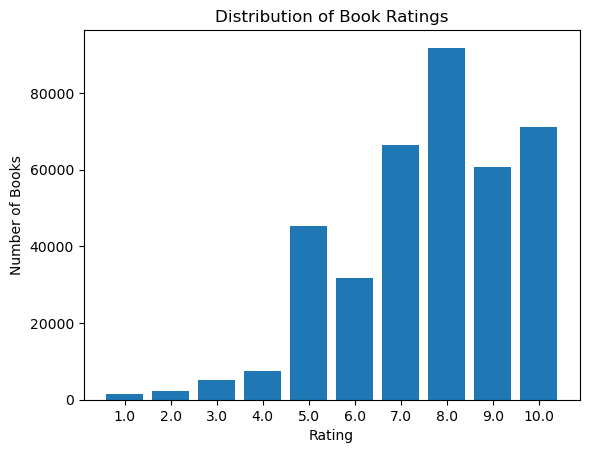

In [70]:
# Distribution of Ratings (y = book-ratings, x = book)
rating_sort = df_ratings_books['Book-Rating'].value_counts().reset_index(drop=False).sort_values('Book-Rating').reset_index(drop=True)
x = rating_sort['Book-Rating']
y = rating_sort['count']
plt.bar(x,y, tick_label=x)
plt.title('Distribution of Book Ratings')
plt.xlabel("Rating")
plt.ylabel("Number of Books")

Text(0.5, 0, 'Book Title')

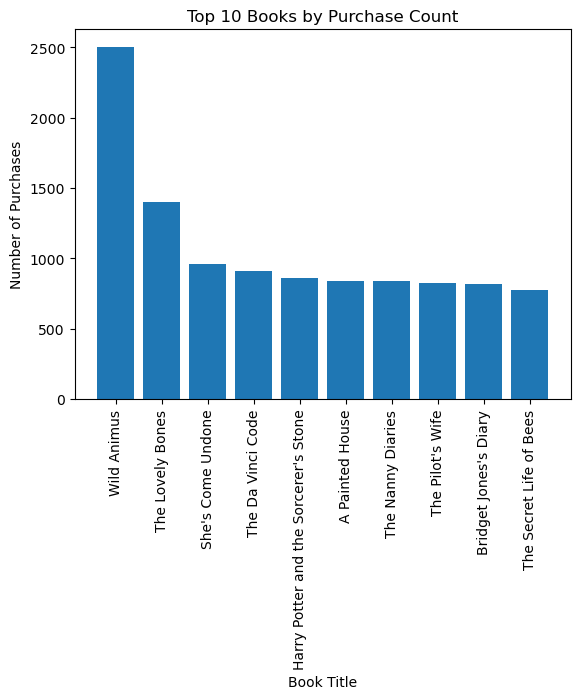

In [71]:
# Most Purchased books
book_sort = df_ratings_books.groupby("Book-Title").count().sort_values("User-ID", ascending=False)
book_sort = book_sort[0:10]
y = book_sort['User-ID']
x = book_sort.index.values
plt.bar(x,y)
plt.xticks(rotation=90)
plt.title("Top 10 Books by Purchase Count")
plt.ylabel("Number of Purchases")
plt.xlabel("Book Title")

Text(0.5, 0, 'Book Title')

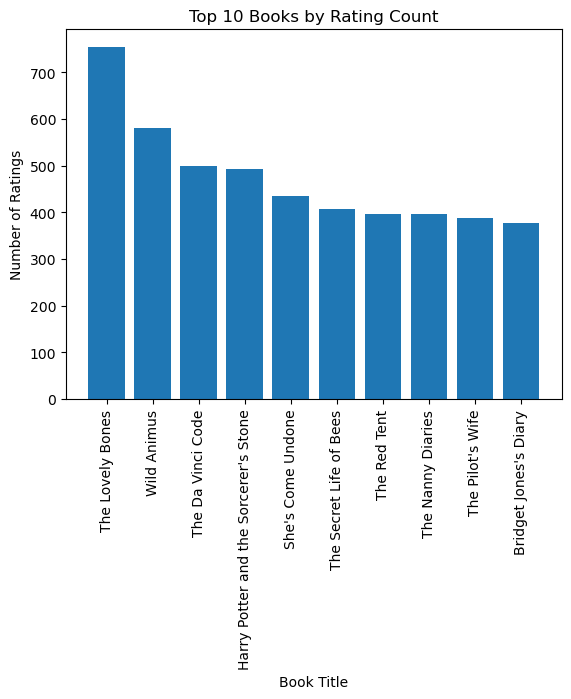

In [72]:
# Most Rated Books (counts by book-title)
rating_sort = df_ratings_books.groupby("Book-Title").count().sort_values("Book-Rating", ascending=False)
rating_sort = rating_sort[0:10]
x = rating_sort.index.values
y = rating_sort['Book-Rating']
plt.bar(x,y)
plt.xticks(rotation=90)
plt.title("Top 10 Books by Rating Count")
plt.ylabel("Number of Ratings")
plt.xlabel("Book Title")

In [73]:
# Exporting csv for use in data exploration

df_ratings_books.to_csv("../books_ratings_clean_notfiltered.csv", index=False)

## Preprocessing - Step 1
### Handling User-IDs with multiple purchases of the same book with different ISBN codes.  
Construction of the pivot table for the recommendation model relies on unique index values.  Book-Titles are being used for the pivot table index, so the Book-Title of Users with multiple purchases of the same book need to be aggregated, along with the Book-Ratings.  

In [74]:
# Finding the books that have the same title but different ISBN
# groupby Book title - count number of ISBN

df_ratings_books.groupby(['Book-Title']).nunique().sort_values('ISBN', ascending=False)


,User-ID,ISBN,Book-Rating,Book-Author,Year-Of-Publication,Publisher,Image-URL-M
Book-Title,,,,,,,
Selected Poems,39,26,7,24,16,20,26
Little Women,62,24,5,4,17,20,24
Wuthering Heights,179,21,10,2,15,18,21
The Secret Garden,140,20,6,3,11,16,20
Dracula,76,20,5,5,13,19,20
...,...,...,...,...,...,...,...
Hints and Help from Heloise,1,1,0,1,1,1,1
Hints from Heloise,1,1,0,1,1,1,1
Hints from Heloise Co,2,1,1,1,1,1,1


In [75]:
# Grouping by User-ID and finding the number of unique values
# Is there a disparity between number of unique book titles and number of ISBNs

df_ratings_books.groupby(['User-ID']).nunique().sort_values('Book-Title', ascending=False)

# Difference in unique number of ISBN and Book-Title indicate that some users have multiples of the same book with different ISBNs

,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-M
User-ID,,,,,,,
11676,11144,10,10555,6354,63,1869,11144
198711,6456,7,6360,3559,57,892,6456
98391,5779,6,5739,3259,9,359,5779
153662,5814,9,5711,3354,46,640,5814
35859,5646,10,5534,3177,50,698,5646
...,...,...,...,...,...,...,...
119043,1,1,1,1,1,1,1
119045,1,0,1,1,1,1,1
119051,1,1,1,1,1,1,1


In [76]:
# lets look at user 11676 - this User has purchased 'Bridget Jones's Diary' 5 times, but rated it only three times
# Duplicate book titles for the same User-ID will not be able to be converted to a pivot table

df_ratings_books.loc[(df_ratings_books['User-ID']== 11676) & (df_ratings_books['Book-Title']=="Bridget Jones's Diary"),:]


,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-M
2366,11676,0330332775,NaN,Bridget Jones's Diary,Helen Fielding,1997,Picador (UK),http://images.amazon.com/images/P/0330332775.0...
97295,11676,0670880728,5.0,Bridget Jones's Diary,Helen Fielding,1998,Viking Books,http://images.amazon.com/images/P/0670880728.0...
174146,11676,0330375253,6.0,Bridget Jones's Diary,Helen Fielding,2001,Picador,http://images.amazon.com/images/P/0330375253.0...
177009,11676,014028009X,8.0,Bridget Jones's Diary,Helen Fielding,1999,Penguin Books,http://images.amazon.com/images/P/014028009X.0...
355099,11676,0141000198,NaN,Bridget Jones's Diary,Helen Fielding,2001,Penguin Putnam,http://images.amazon.com/images/P/0141000198.0...


In [77]:
# Removing the duplicate book-titles for single users by using group-by
# Averaging the book-ratings for purchases -- does not include NaN (books that were purchased but not rated)

df_rm_multi = df_ratings_books.groupby(["User-ID", "Book-Title"])['Book-Rating'].mean().reset_index()

print(f'The dataframe was reduced by {len(df_ratings_books)-len(df_rm_multi)}, from {len(df_ratings_books)} to {len(df_rm_multi)}, after removing duplicate book-titles for individual users')

The dataframe was reduced by 4928, from 1031136 to 1026208, after removing duplicate book-titles for individual users


In [78]:
df_rm_multi.head()

,User-ID,Book-Title,Book-Rating
0,2,Classical Mythology,NaN
1,8,A Second Chicken Soup for the Woman's Soul (Ch...,NaN
2,8,Clara Callan,5.0
3,8,Decision in Normandy,NaN
4,8,Flu: The Story of the Great Influenza Pandemic...,NaN


In [79]:
# Confirmation of removal of duplicate Book-Titles for User-ID 11676
# Only one entry for 'Bridget Jones's Diary', and the Rating is successfully averaged

df_rm_multi.loc[(df_rm_multi['User-ID']== 11676) & (df_rm_multi['Book-Title']=="Bridget Jones's Diary"),:]


,User-ID,Book-Title,Book-Rating
32501,11676,Bridget Jones's Diary,6.333333


## Preprocessing Data - Step 2
To make our model more robust, filtering users will low number of ratings and books with low number of ratings.
We do not want the model skewed by users that do not have a wide variety of book purchases with associated ratings, and books that only have a few ratings.

Text(0, 0.5, 'Number of Ratings')

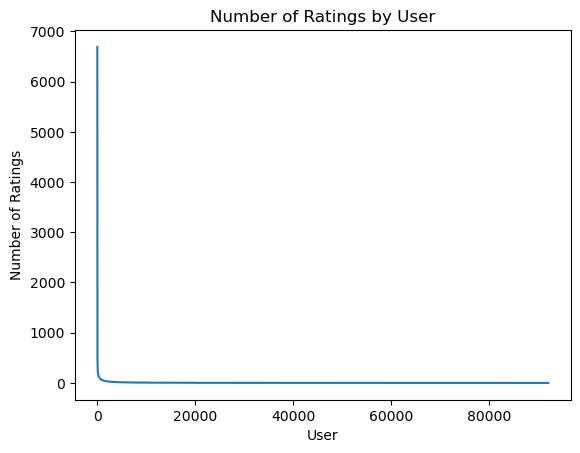

In [80]:
# Visualizing rating frequency by user-id

data = df_rm_multi.groupby('User-ID').count().sort_values("Book-Rating", ascending=False).reset_index(drop=False)
x = data.index.values
y = data['Book-Rating'].tolist()

plt.plot(x,y)
plt.title("Number of Ratings by User")
plt.xlabel("User")
plt.ylabel("Number of Ratings")

Text(0, 0.5, 'Number of Ratings')

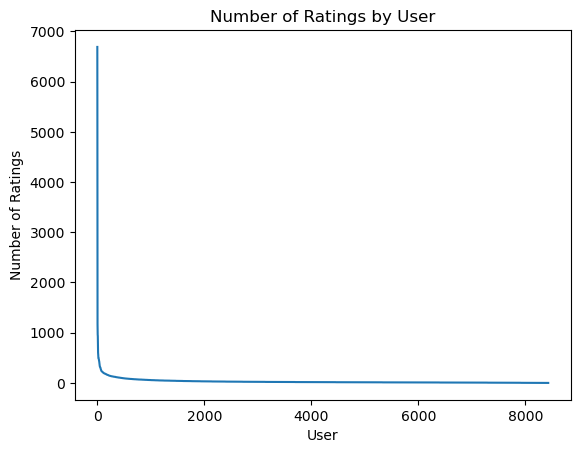

In [81]:
# Filtering out Users with less than 15 reviews
df_rm1 = df_rm_multi.groupby('User-ID').filter(lambda x: x['User-ID'].count() >= 15).reset_index(drop=True)

# Graphing
data = df_rm1.groupby('User-ID').count().sort_values("Book-Rating", ascending=False).reset_index(drop=False)
x = data.index.values
y = data['Book-Rating'].tolist()

plt.plot(x,y)
plt.title("Number of Ratings by User")
plt.xlabel("User")
plt.ylabel("Number of Ratings")

In [82]:
df_rm1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825305 entries, 0 to 825304
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   User-ID      825305 non-null  int32  
 1   Book-Title   825305 non-null  object 
 2   Book-Rating  267249 non-null  float64
dtypes: float64(1), int32(1), object(1)
memory usage: 15.7+ MB


Text(0, 0.5, 'Number of Ratings')

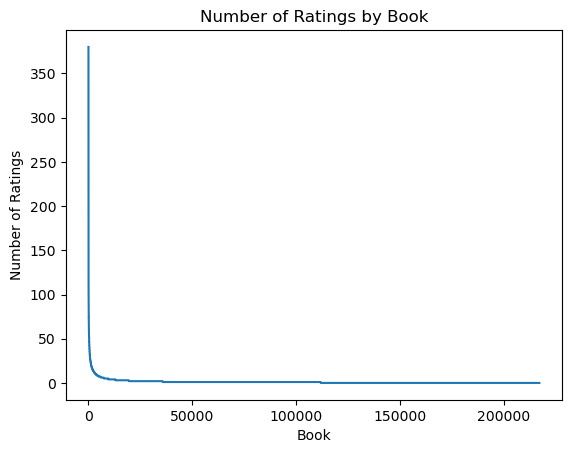

In [83]:
# Graphing Rating frequency of books by book title
# x = book-title, y = # of ratings

data = df_rm1.groupby('Book-Title').count().sort_values("Book-Rating", ascending=False).reset_index(drop=True)
x = data.index.values
y = data['Book-Rating'].tolist()

plt.plot(x,y)
plt.title("Number of Ratings by Book")
plt.xlabel("Book")
plt.ylabel("Number of Ratings")

In [84]:
# Filtering out Book-Title with less than 50 reviews

df_rm2 = df_rm1.groupby('Book-Title').filter(lambda x: x['Book-Title'].count() >= 50).reset_index(drop=True)
df_rm2.head()

,User-ID,Book-Title,Book-Rating
0,8,The Kitchen God's Wife,NaN
1,242,Fahrenheit 451,8.0
2,242,The Martian Chronicles,10.0
3,242,Wild Animus,NaN
4,243,2nd Chance,NaN


Text(0, 0.5, 'Number of Ratings')

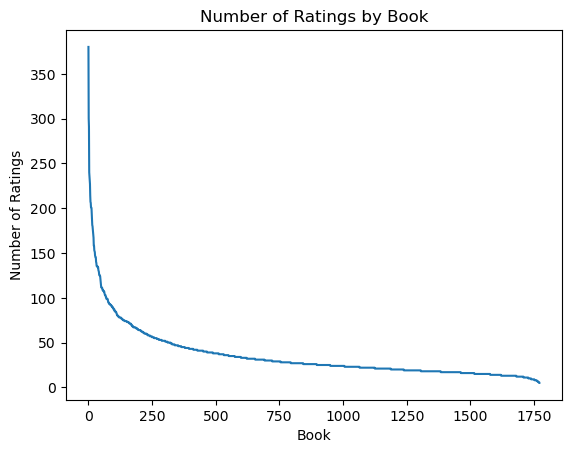

In [85]:
# Graphing Rating frequency of books by book title
# x = book-title, y = # of ratings

data = df_rm2.groupby('Book-Title').count().sort_values("Book-Rating", ascending=False).reset_index(drop=True)
x = data.index.values
y = data['Book-Rating'].tolist()

plt.plot(x,y)
plt.title("Number of Ratings by Book")
plt.xlabel("Book")
plt.ylabel("Number of Ratings")

In [86]:
df_rm2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186521 entries, 0 to 186520
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   User-ID      186521 non-null  int32  
 1   Book-Title   186521 non-null  object 
 2   Book-Rating  63219 non-null   float64
dtypes: float64(1), int32(1), object(1)
memory usage: 3.6+ MB


In [87]:
df_rm2.nunique()

User-ID        7894
Book-Title     1772
Book-Rating      26
dtype: int64

In [88]:
df_rm2.to_csv("../book_rating_cleandf.csv", index=False)

In [89]:
# Creating Pivot table of Book-Title, User-ID, and Book-Rating for input into knn model
df_clean_br = df_rm2.copy()
books_users=df_clean_br.pivot_table(index='Book-Title', columns='User-ID', values='Book-Rating').fillna(0)


In [90]:
books_users.head()

User-ID,242,243,254,383,388,446,487,503,505,507,...,278314,278346,278356,278390,278418,278535,278582,278633,278843,278851
Book-Title,,,,,,,,,,,,,,,,,,,,,
10 Lb. Penalty,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16 Lighthouse Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1984,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0
2010: Odyssey Two,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
size = books_users.shape
print(f'This model contains: {size[0]} books, and {size[1]} users.')

This model contains: 1772 books, and 6943 users.


### Sparsity Assessment
Sparsity is an assessment of the number of zeros in the dataset.  If the dataset is too sparse (high proportion of zeros) the model fit may be poor.  Target sparsity of <99.5%. 

In [92]:
# Determine sparsity of the matrix - want at least 0.1 of cells to have information
sparsity = np.count_nonzero(books_users)/books_users.size
print(f' {round(sparsity*100, 1)}% of the dataset are numbers.')

 0.5% of the dataset are numbers.


This dataset is adequate for input in the model.

In [93]:
# creating a Sparse matrix for the knn model
# CSR - compresses sparse row matrices - splits non-zero values of matrix into three arrays - value/column/row
# less memory usage and greater speed of model training
matrix_books_users = csr_matrix(books_users.values)

# Model Construction - Item Based Collaborative Filtering

In [94]:
# Cosine similarity
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')

In [95]:
# create a function that takes a book name and returns recommendations
def recommender(book_name, data, model, n_recommendations):
    model.fit(data)
    global idx
    idx=process.extractOne(book_name,books_users.index)[0]
    idxnum=books_users.index.get_loc(idx)
    print(f'Book Query: {idx}')
    print('')
    distances, indices = model.kneighbors(data[idxnum], n_neighbors=n_recommendations)
    global book_list
    global score_list
    book_list = []
    score_list=[]
    for j in distances[0]:
        score_list.append(j)
    for i in indices[0]:
        book_list.append(books_users.index[i])
    return book_list
    
def print_recommender(book_name, data, model, n_recommendations):
    recommender(book_name, data, model, n_recommendations)
    print(f'Your top 5 recommended books are:')
    counter = 0
    
    for book in book_list:
        author = df_ratings_books.loc[df_ratings_books["Book-Title"] == book , :]['Book-Author'].tolist()[0]
        if book != idx:    
            counter = counter + 1
            print(f"{counter}. {book} -- by {author} -- Cosine Distance {round(score_list[counter], 2)}")
            if counter == 5:
                break
    author_list=[]
    for book in book_list:
        author = df_ratings_books.loc[df_ratings_books["Book-Title"] == book, :]['Book-Author'].tolist()[0]
        if author not in author_list:
            author_list.append(author)
    print("")
    print('Authors you can try:')
    counter = 0
    for author in author_list:
        counter = counter + 1
        print(f'{counter}. {author}')
        if counter == 5:
                break



In [145]:
print_recommender("jurassic park", matrix_books_users, model_knn, 20)

Book Query: Jurassic Park

Your top 5 recommended books are:
1. The Lost World -- by Michael Crichton -- Cosine Distance 0.79
2. Congo -- by Michael Crichton -- Cosine Distance 0.84
3. Silence of the Lambs -- by Thomas Harris -- Cosine Distance 0.86
4. Rising Sun -- by MICHAEL CRICHTON -- Cosine Distance 0.87
5. Red Dragon -- by Thomas Harris -- Cosine Distance 0.88

Authors you can try:
1. Michael Crichton
2. Thomas Harris
3. MICHAEL CRICHTON
4. John Grisham
5. Stephen King


In [97]:
print_recommender("the lovely bones", matrix_books_users, model_knn, 20)

Book Query: The Lovely Bones

Your top 5 recommended books are:
1. Lucky : A Memoir -- by Alice Sebold -- Cosine Distance 0.83
2. Where the Heart Is -- by Billie Letts -- Cosine Distance 0.83
3. She's Come Undone -- by Wally Lamb -- Cosine Distance 0.84
4. The Pilot's Wife -- by Anita Shreve -- Cosine Distance 0.85
5. The Secret Life of Bees -- by Sue Monk Kidd -- Cosine Distance 0.86

Authors you can try:
1. Alice Sebold
2. Billie Letts
3. Wally Lamb
4. Anita Shreve
5. Sue Monk Kidd


In [98]:
print_recommender("harry potter and the chamber of secrets", matrix_books_users, model_knn, 30)

Book Query: Harry Potter and the Chamber of Secrets

Your top 5 recommended books are:
1. Harry Potter and the Prisoner of Azkaban -- by J. K. Rowling -- Cosine Distance 0.4
2. Harry Potter and the Goblet of Fire -- by J. K. Rowling -- Cosine Distance 0.41
3. Harry Potter and the Sorcerer's Stone -- by J. K. Rowling -- Cosine Distance 0.44
4. Harry Potter and the Order of the Phoenix -- by J. K. Rowling -- Cosine Distance 0.6
5. The Fellowship of the Ring (The Lord of the Rings, Part 1) -- by J.R.R. Tolkien -- Cosine Distance 0.81

Authors you can try:
1. J. K. Rowling
2. J.R.R. Tolkien
3. Lemony Snicket
4. E. B. White
5. Harper Lee


In [99]:
print_recommender("the secret life of bees", matrix_books_users, model_knn, 15)

Book Query: The Secret Life of Bees

Your top 5 recommended books are:
1. Three Junes -- by JULIA GLASS -- Cosine Distance 0.85
2. The Five People You Meet in Heaven -- by Mitch Albom -- Cosine Distance 0.85
3. Good in Bed -- by Jennifer Weiner -- Cosine Distance 0.85
4. The Lovely Bones -- by Alice Sebold -- Cosine Distance 0.86
5. Tears of the Giraffe (No.1 Ladies Detective Agency) -- by Alexander McCall Smith -- Cosine Distance 0.86

Authors you can try:
1. Sue Monk Kidd
2. JULIA GLASS
3. Mitch Albom
4. Jennifer Weiner
5. Alice Sebold


# Model Assessment


Creating a new dataframe with grouped statistics to observe users with the most ratings and books with the most ratings.

In [100]:
# Dataframe of counts Users and Ratings by Book
counts_of_books = df_clean_br.groupby(['Book-Title']).count().reset_index()
counts_of_books = counts_of_books.rename(columns={"User-ID":"Count_Users_byBook","Book-Rating":"Count_Ratings_byBook"})
counts_of_books

,Book-Title,Count_Users_byBook,Count_Ratings_byBook
0,10 Lb. Penalty,51,15
1,16 Lighthouse Road,60,15
2,1984,179,89
3,1st to Die: A Novel,344,135
4,2010: Odyssey Two,76,23
...,...,...,...
1767,Year of Wonders,118,54
1768,You Belong To Me,95,28
1769,Zen and the Art of Motorcycle Maintenance: An ...,126,46
1770,Zoya,92,16


In [101]:
# Dataframe of counts Books and Ratings by User-ID
counts_of_users = df_clean_br.groupby(['User-ID']).count().reset_index()
counts_of_users = counts_of_users.rename(columns={"Book-Title":"Count_Books_byUser","Book-Rating":"Count_Ratings_byUser"})
counts_of_users

,User-ID,Count_Books_byUser,Count_Ratings_byUser
0,8,1,0
1,242,3,2
2,243,60,16
3,254,83,18
4,383,8,1
...,...,...,...
7889,278582,17,12
7890,278633,40,22
7891,278637,1,0
7892,278843,22,11


In [102]:
# Merged Dataframe - original DF used for model, and the counts dataframes
rating_counts_df = df_clean_br.merge(counts_of_books, on="Book-Title", how='left').reset_index(drop=True)
rating_counts_df = rating_counts_df.merge(counts_of_users, on="User-ID", how='left').reset_index(drop=True)
rating_counts_df

,User-ID,Book-Title,Book-Rating,Count_Users_byBook,Count_Ratings_byBook,Count_Books_byUser,Count_Ratings_byUser
0,8,The Kitchen God's Wife,NaN,241,74,1,0
1,242,Fahrenheit 451,8.0,281,124,3,2
2,242,The Martian Chronicles,10.0,54,23,3,2
3,242,Wild Animus,NaN,1226,201,3,2
4,243,2nd Chance,NaN,265,99,60,16
...,...,...,...,...,...,...,...
186516,278843,The Pilot's Wife,NaN,511,206,22,11
186517,278843,The Return Journey,NaN,120,28,22,11
186518,278843,The Secret Garden,NaN,112,48,22,11
186519,278843,While I Was Gone,NaN,279,78,22,11


In [103]:
# Defining a function that returns info_list (dictionary of values from loc statement that filters for the User-ID, Book-Title, and Book-Rating by recommended book)
def datacheck(userinput, book_list):
    userbooklist = rating_counts_df.loc[(rating_counts_df['User-ID']== userinput),["Book-Title"]]['Book-Title'].tolist()
    global info_list
    info_list = []
    for book in book_list:
        if book in userbooklist:
            info = rating_counts_df.loc[(rating_counts_df['User-ID']==userinput) & (rating_counts_df['Book-Title'] == book),:]
            data = {'User-ID':info.iloc[0]['User-ID'], "Book-Title":info.iloc[0]['Book-Title'], "Book-Rating":info.iloc[0]['Book-Rating']}    
            info_list.append(data)
        else:
            data = {'User-ID':userinput, "Book-Title":book, "Book-Rating":0}
            info_list.append(data)
    return info_list

In [104]:
# Defining a function to create a heatmap of the ratings of the recommended book-title by user
def graph_recommender_accuracy(data, book_title, book_list, id_list):
    norm = mpl.colors.Normalize(vmin=0, vmax=10)
    fig, ax = plt.subplots()
    im = ax.imshow(data, cmap='plasma_r', norm=norm)
    ax.set_xticks(np.arange(len(book_list)), labels=book_list)
    ax.set_yticks(np.arange(len(id_list)), labels=id_list)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.colorbar(im)
    plt.title(book_title)
    plt.ylabel("UserID")
    plt.xlabel("Recommended Book")

    # Loop over data dimensions and create text annotations.
    for i in range(len(id_list)):
        for j in range(len(book_list)):
            text = ax.text(j, i, rating[i, j],
                           ha="center", va="center", color="w", size=8)
    plt.show()

## Testing Books with Strongest backing of ratings

#### Step 1: Finding the Book-titles with the most number of ratings.  
#### Step 2: Individually assessing the books with the highest number of ratings by:  

    1. Running the recommender model on candidate book to find top 15 recommended books.  
    2. Finding users that rated the candidate book >=8/10.  
    2. Of those users, creating a list of 5 users that rated the most number of books.  
    3. Creating a heatmap of the user's rating, if available, of the top 15 recommended books.  

## Step 1: Finding the Book-Titles with the most number of ratings

In [105]:
book_check = counts_of_books.sort_values('Count_Ratings_byBook', ascending=False)
book_check.head(10)

,Book-Title,Count_Users_byBook,Count_Ratings_byBook
1443,The Lovely Bones,839,380
564,Harry Potter and the Sorcerer's Stone,558,300
1295,The Da Vinci Code,595,291
1073,She's Come Undone,608,240
560,Harry Potter and the Chamber of Secrets,421,236
1546,The Secret Life of Bees,518,232
227,Bridget Jones's Diary,528,227
563,Harry Potter and the Prisoner of Azkaban,337,214
1517,The Red Tent,476,207
1494,The Pilot's Wife,511,206


## Step 2: Individual Assessment of Book-Ratings from Recommendation Model
Visualization of User-Ratings of Recommended Books based on >=8/10 rated book.

In [106]:
# Creating a function that returns a list of 10 users that rate the book >=8/10 and have the highest count of ratings in the dataset
def getting_id_list(book_title):
    global id_list
    book_by_user_df = rating_counts_df.loc[(rating_counts_df['Book-Title'] == book_title) & (rating_counts_df['Book-Rating'] >= 8),:].sort_values(['Count_Ratings_byUser'], ascending=False)
    id_list = book_by_user_df['User-ID'].tolist()[0:10]
    return id_list

In [107]:
# Creating a function that takes the id_list and book_list to query
# Calls the datacheck function that returns info_list (rating information of books from book_list by id from id_list)
# Creates a dataframe for each user with their ratings
# Replaces any 0's with NaN so they will not appear on the heatmap
# Creates an array of books ratings
# Creates a 2D array of book rating by user for the heatmap
# Calls the graph_recommender_accuracy function to create a heatmap of the array

def assessment_heatmap(id_list, book_list):
    # Visualizing User Ratings of books from Recommendation Model
    datacheck(id_list[0], book_list)
    id_1 = pd.DataFrame(info_list)
    id_1.replace(0, np.nan, inplace=True)

    datacheck(id_list[1], book_list)
    id_2 = pd.DataFrame(info_list)
    id_2.replace(0, np.nan, inplace=True)

    datacheck(id_list[2], book_list)
    id_3 = pd.DataFrame(info_list)
    id_3.replace(0, np.nan, inplace=True)

    datacheck(id_list[3], book_list)
    id_4 = pd.DataFrame(info_list)
    id_4.replace(0, np.nan, inplace=True)

    datacheck(id_list[4], book_list)
    id_5 = pd.DataFrame(info_list)
    id_5.replace(0, np.nan, inplace=True)
    
    datacheck(id_list[5], book_list)
    id_6 = pd.DataFrame(info_list)
    id_6.replace(0, np.nan, inplace=True)
    
    datacheck(id_list[6], book_list)
    id_7 = pd.DataFrame(info_list)
    id_7.replace(0, np.nan, inplace=True)

    datacheck(id_list[7], book_list)
    id_8 = pd.DataFrame(info_list)
    id_8.replace(0, np.nan, inplace=True)

    datacheck(id_list[8], book_list)
    id_9 = pd.DataFrame(info_list)
    id_9.replace(0, np.nan, inplace=True)
    
    datacheck(id_list[9], book_list)
    id_10 = pd.DataFrame(info_list)
    id_10.replace(0, np.nan, inplace=True)
    
    s1 = np.asarray(id_1['Book-Rating'].tolist()) 
    s2 = np.asarray(id_2['Book-Rating'].tolist())
    s3 = np.asarray(id_3['Book-Rating'].tolist())
    s4 = np.asarray(id_4['Book-Rating'].tolist())
    s5 = np.asarray(id_5['Book-Rating'].tolist())
    s6 = np.asarray(id_6['Book-Rating'].tolist())
    s7 = np.asarray(id_7['Book-Rating'].tolist())
    s8 = np.asarray(id_8['Book-Rating'].tolist())
    s9 = np.asarray(id_9['Book-Rating'].tolist())
    s10 = np.asarray(id_10['Book-Rating'].tolist())

    # Creating numpy array of user book rating information
    global rating
    rating = np.array([s1, s2, s3, s4, s5, s6, s7, s8, s9, s10]).round()


    graph_recommender_accuracy(rating, book_title, book_list, id_list)

### The Lovely Bones

In [108]:
# Finding Users to assess
book_title = "The Lovely Bones"
getting_id_list(book_title)

[16795, 95359, 98391, 204864, 89602, 235105, 112001, 261829, 76151, 254465]

In [109]:
# Running book recommender
recommender(book_title, matrix_books_users, model_knn, 15)
print(book_list)

Book Query: The Lovely Bones

['The Lovely Bones', 'Lucky : A Memoir', 'Where the Heart Is', "She's Come Undone", "The Pilot's Wife", 'The Secret Life of Bees', 'The Da Vinci Code', 'Life of Pi', "Suzanne's Diary for Nicholas", 'Good in Bed', "White Oleander : A Novel (Oprah's Book Club)", "The Book of Ruth (Oprah's Book Club (Paperback))", 'A Painted House', 'Lucky', 'The Pact: A Love Story']


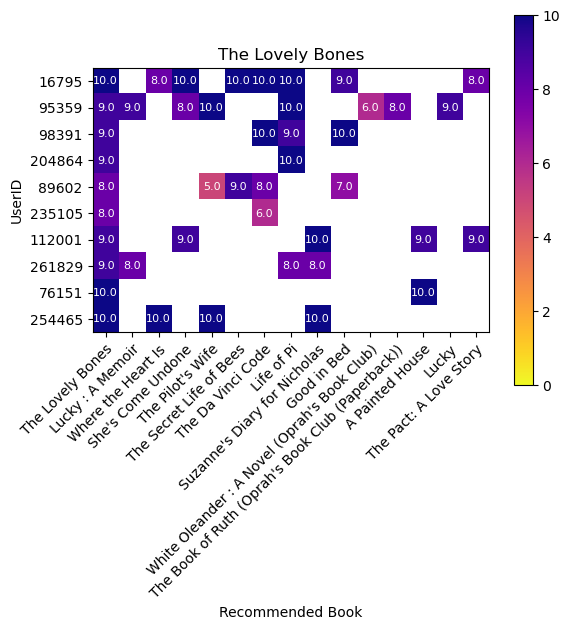

In [110]:
# Creating heatmap of Users that Rated Query book 10, and their ratings for books in the recommended book list
assessment_heatmap(id_list, book_list)

### Harry Potter and the Sorcerer's Stone

In [111]:
# Finding Users
book_title = "Harry Potter and the Sorcerer's Stone"
getting_id_list(book_title)

[11676, 104636, 153662, 35859, 162639, 189835, 7346, 46398, 232131, 242083]

In [112]:
# Running book recommender
recommender(book_title, matrix_books_users, model_knn, 15)
print(book_list)

Book Query: Harry Potter and the Sorcerer's Stone

["Harry Potter and the Sorcerer's Stone", 'Harry Potter and the Chamber of Secrets', 'Harry Potter and the Prisoner of Azkaban', 'Harry Potter and the Goblet of Fire', 'Harry Potter and the Order of the Phoenix', 'The Fellowship of the Ring (The Lord of the Rings, Part 1)', 'The Two Towers (The Lord of the Rings, Part 2)', 'The Return of the King (The Lord of the Rings, Part 3)', 'Anne of Ingleside (Anne of Green Gables Novels (Paperback))', 'The Hobbit: or There and Back Again', 'The Hobbit : The Enchanting Prelude to The Lord of the Rings', 'Anne of Windy Poplars (Anne of Green Gables Novels (Paperback))', 'Charlie and the Chocolate Factory', 'Anne of the Island', 'Dune Messiah (Dune Chronicles, Book 2)']


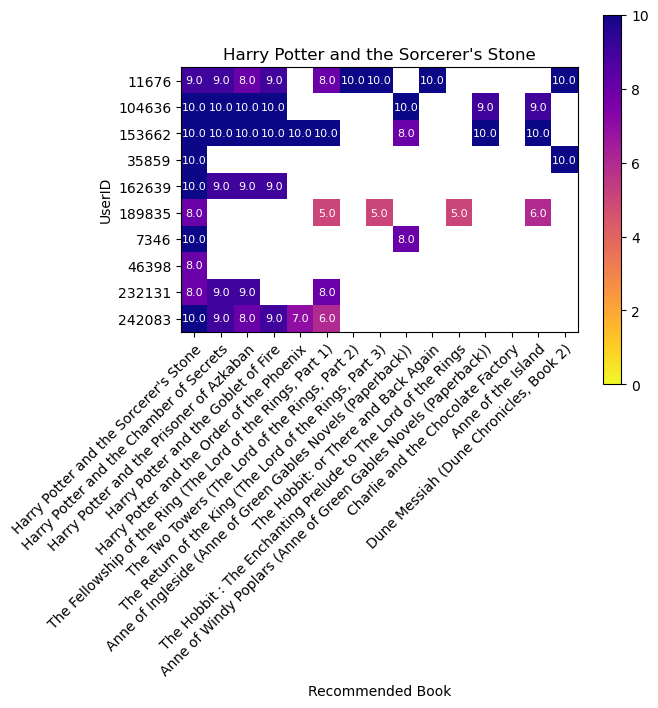

In [113]:
# Creating heatmap of Users that Rated Query book 10, and their ratings for books in the recommended book list
assessment_heatmap(id_list, book_list)

### The Da Vinci Code

In [114]:
# Finding Users
book_title = 'The Da Vinci Code'
getting_id_list(book_title)

[11676, 16795, 98391, 13552, 89602, 31826, 232131, 68555, 107784, 227705]

In [115]:
# Running book recommender
recommender(book_title, matrix_books_users, model_knn, 15)
print(book_list)

Book Query: The Da Vinci Code

['The Da Vinci Code', 'Angels & Demons', 'Digital Fortress : A Thriller', 'Middlesex: A Novel', 'The Lovely Bones', 'The Secret Life of Bees', 'Touching Evil', 'No Second  Chance', 'Nights in Rodanthe', 'The Red Tent', "The Sweet Potato Queens' Book of Love", 'The Curious Incident of the Dog in the Night-Time (Today Show Book Club #13)', 'The Five People You Meet in Heaven', 'Sea Glass: A Novel', 'The Face']


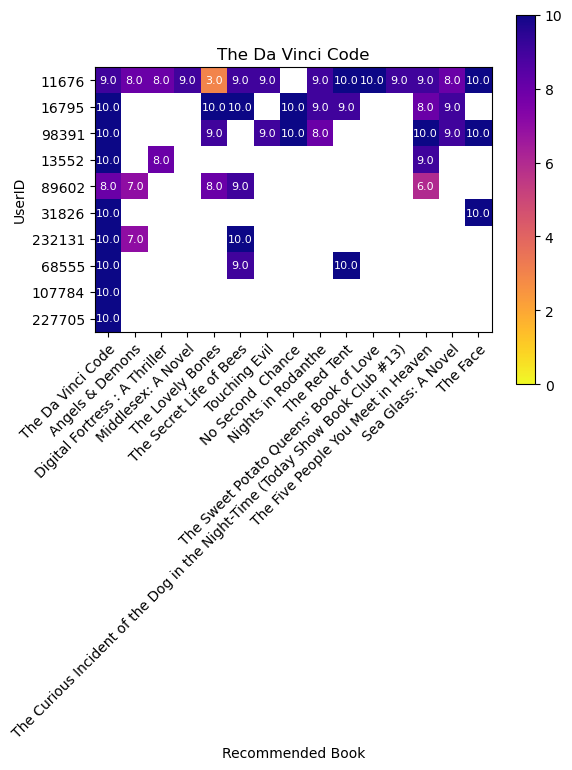

In [116]:
# Creating heatmap of Users that Rated Query book 10, and their ratings for books in the recommended book list
assessment_heatmap(id_list, book_list)

### She's Come Undone

In [117]:
# Finding Users
book_title = "She's Come Undone"
getting_id_list(book_title)

[16795, 104636, 95359, 225087, 112001, 126492, 232131, 210485, 114544, 235282]

In [118]:
# Running book recommender
recommender(book_title, matrix_books_users, model_knn, 15)
print(book_list)

Book Query: She's Come Undone

["She's Come Undone", 'I Know This Much Is True', 'The Lovely Bones', 'Where the Heart Is', 'We Were the Mulvaneys', "I Know This Much Is True (Oprah's Book Club)", "The Pilot's Wife", "Songs in Ordinary Time (Oprah's Book Club (Paperback))", 'The Nanny Diaries', 'To Kill a Mockingbird', 'The Secret Life of Bees', 'Summer Sisters', "The Deep End of the Ocean (Oprah's Book Club (Hardcover))", 'Divine Secrets of the Ya-Ya Sisterhood: A Novel', 'White Oleander : A Novel']


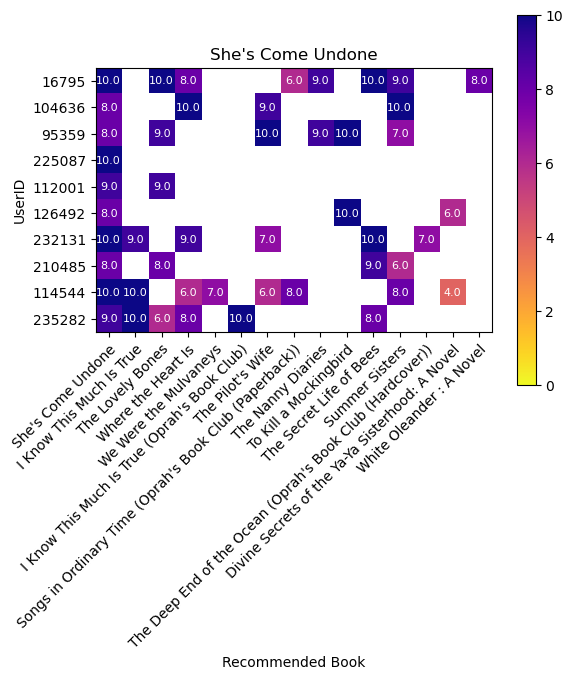

In [119]:
# Creating heatmap of Users that Rated Query book 10, and their ratings for books in the recommended book list
assessment_heatmap(id_list, book_list)

### Harry Potter and the Chamber of Secrets

In [120]:
# Finding Users
book_title = 'Harry Potter and the Chamber of Secrets'
getting_id_list(book_title)

[11676, 104636, 153662, 162639, 21014, 110934, 232131, 37950, 110973, 23872]

In [121]:
# Running book recommender
recommender(book_title, matrix_books_users, model_knn, 15)
print(book_list)

Book Query: Harry Potter and the Chamber of Secrets

['Harry Potter and the Chamber of Secrets', 'Harry Potter and the Prisoner of Azkaban', 'Harry Potter and the Goblet of Fire', "Harry Potter and the Sorcerer's Stone", 'Harry Potter and the Order of the Phoenix', 'The Fellowship of the Ring (The Lord of the Rings, Part 1)', 'The Two Towers (The Lord of the Rings, Part 2)', 'The Reptile Room (A Series of Unfortunate Events, Book 2)', "Charlotte's Web (Trophy Newbery)", 'The Hobbit: or There and Back Again', 'The Bad Beginning (A Series of Unfortunate Events, Book 1)', 'To Kill a Mockingbird', 'The Return of the King (The Lord of the Rings, Part 3)', 'The Wide Window (A Series of Unfortunate Events, Book 3)', 'Charlie and the Chocolate Factory']


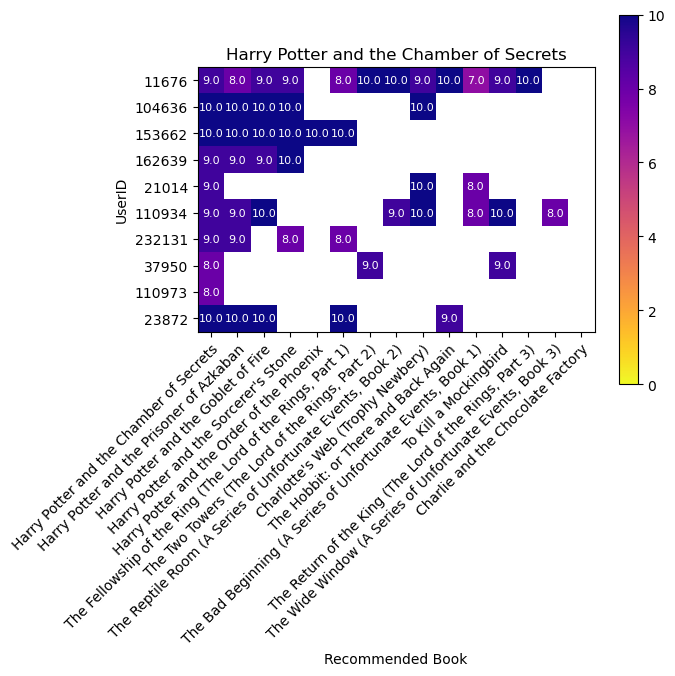

In [122]:
# Creating heatmap of Users that Rated Query book 10, and their ratings for books in the recommended book list
assessment_heatmap(id_list, book_list)

### Bridget Jones's Diary

In [123]:
# Finding Users
book_title = "Bridget Jones's Diary"
getting_id_list(book_title)

[153662, 60244, 13552, 162639, 225087, 23902, 43246, 37712, 254465, 110912]

In [124]:
# Running book recommender
recommender(book_title, matrix_books_users, model_knn, 15)
print(book_list)

Book Query: Bridget Jones's Diary

["Bridget Jones's Diary", 'Bridget Jones: The Edge of Reason', 'Where the Heart Is', 'Angels', 'Milkrun', 'Bridget Jones : The Edge of Reason', 'Zoya', 'Last Chance Saloon', 'Sex &amp; the City', 'Lucky : A Memoir', 'Harry Potter and the Goblet of Fire', 'Billy', "The Girls' Guide to Hunting and Fishing", 'Mr. Maybe', 'Harry Potter and the Chamber of Secrets']


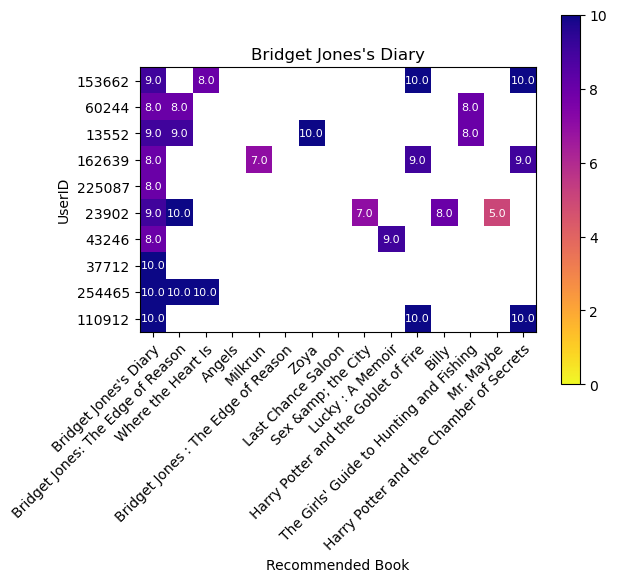

In [125]:
# Creating heatmap of Users that Rated Query book 10, and their ratings for books in the recommended book list
assessment_heatmap(id_list, book_list)

### Wild Animus

In [141]:
# Finding Users
book_title = "Jurassic Park"
getting_id_list(book_title)

[11676, 95359, 162639, 225087, 112001, 7346, 46398, 234828, 185233, 37712]

In [142]:
# Running book recommender
recommender(book_title, matrix_books_users, model_knn, 15)
print(book_list)

Book Query: Jurassic Park

['Jurassic Park', 'The Lost World', 'Congo', 'Silence of the Lambs', 'Rising Sun', 'Red Dragon', 'Sphere', 'The Pelican Brief', 'The Terminal Man', 'Pet Sematary', 'Airframe', 'Postmortem', 'The Gunslinger (The Dark Tower, Book 1)', 'The Bonfire of the Vanities', 'A Time to Kill']


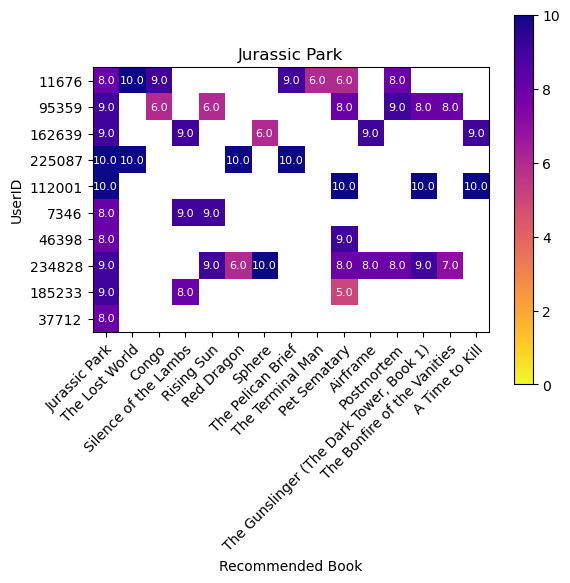

In [143]:
# Creating heatmap of Users that Rated Query book 10, and their ratings for books in the recommended book list
assessment_heatmap(id_list, book_list)

### The Secret Life of Bees

In [129]:
# Finding Users
book_title = "The Secret Life of Bees"
getting_id_list(book_title)

[11676, 16795, 60244, 35859, 89602, 6575, 21014, 232131, 68555, 37712]

In [130]:
# Running book recommender
recommender(book_title, matrix_books_users, model_knn, 15)
print(book_list)

Book Query: The Secret Life of Bees

['The Secret Life of Bees', 'Three Junes', 'The Five People You Meet in Heaven', 'Good in Bed', 'The Lovely Bones', 'Tears of the Giraffe (No.1 Ladies Detective Agency)', 'The Da Vinci Code', 'House of Sand and Fog', 'Blue Shoe', 'Cold Mountain : A Novel', 'The Rapture of Canaan', 'Girl in Hyacinth Blue', 'Wicked: The Life and Times of the Wicked Witch of the West', 'Peace Like a River', "The Pilot's Wife"]


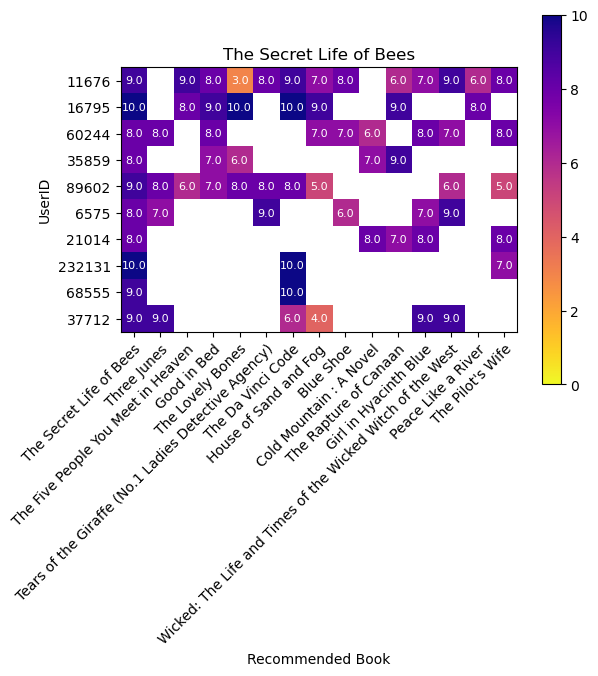

In [131]:
# Creating heatmap of Users that Rated Query book 10, and their ratings for books in the recommended book list
assessment_heatmap(id_list, book_list)

### Life of Pi

In [132]:
# Finding Users
book_title = "Life of Pi"
getting_id_list(book_title)

[16795, 95359, 98391, 204864, 46398, 261829, 91113, 8245, 141444, 115003]

In [133]:
# Running book recommender
recommender(book_title, matrix_books_users, model_knn, 15)
print(book_list)

Book Query: Life of Pi

['Life of Pi', 'The Lovely Bones', 'The Secret Life of Bees', 'The God of Small Things', 'House of Sand and Fog', 'The Red Tent', 'Balzac and the Little Chinese Seamstress : A Novel', 'The Hours: A Novel', 'Girl with a Pearl Earring', 'The Corrections: A Novel', 'The Little Friend', 'Back When We Were Grownups: A Novel', 'The Blind Assassin', 'The Curious Incident of the Dog in the Night-Time (Vintage Contemporaries)', "The Handmaid's Tale : A Novel"]


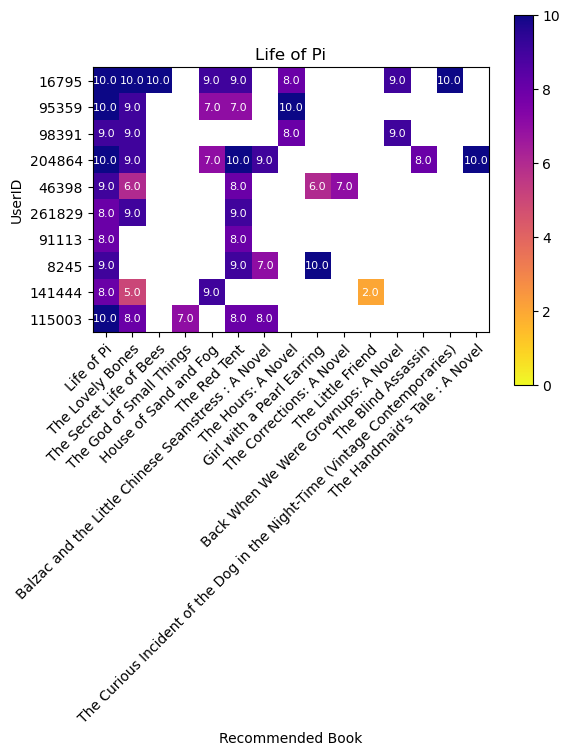

In [134]:
# Creating heatmap of Users that Rated Query book 10, and their ratings for books in the recommended book list
assessment_heatmap(id_list, book_list)

### The Nanny Diaries: A Novel

In [135]:
# Finding Users
book_title = "The Nanny Diaries"
getting_id_list(book_title)

[16795, 95359, 60244, 35859, 235105, 271448, 105979, 88693, 216683, 36606]

In [136]:
# Running book recommender
recommender(book_title, matrix_books_users, model_knn, 15)
print(book_list)

Book Query: The Nanny Diaries

['The Nanny Diaries', 'Confessions of a Shopaholic (Summer Display Opportunity)', 'Shopaholic Takes Manhattan (Summer Display Opportunity)', "The Girls' Guide to Hunting and Fishing", 'The Devil Wears Prada : A Novel', 'Bridget Jones: The Edge of Reason', 'Lucky', "She's Come Undone", 'Blue Diary', 'The Catcher in the Rye', "The Dive From Clausen's Pier : A Novel (Vintage Contemporaries (Paperback))", 'Good in Bed', 'The Five People You Meet in Heaven', 'Four Blondes', "Patty Jane's House of Curl (Ballantine Reader's Circle)"]


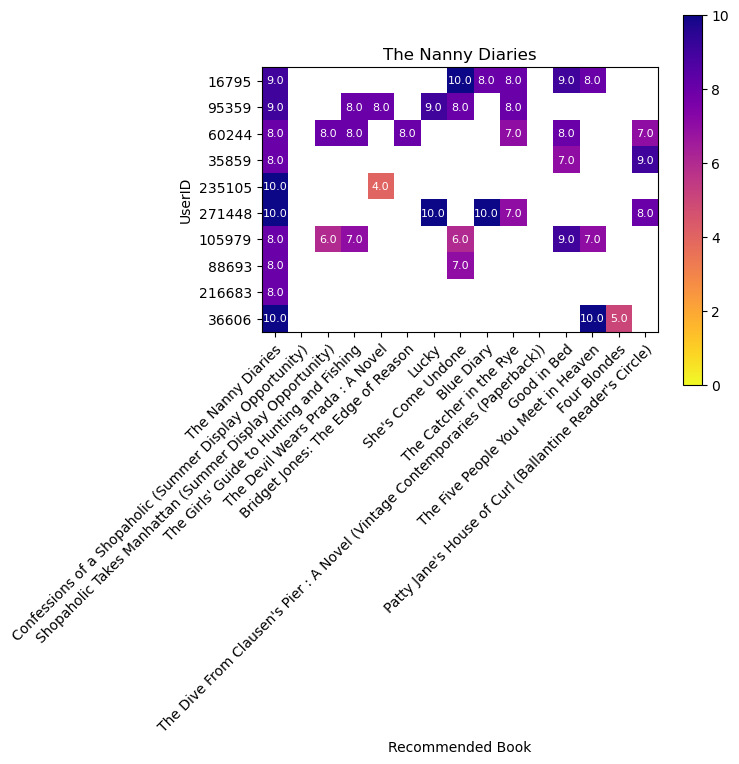

In [137]:
# Creating heatmap of Users that Rated Query book 10, and their ratings for books in the recommended book list
assessment_heatmap(id_list, book_list)

### The Red Tent

In [138]:
# Finding Users
book_title = "The Red Tent"
getting_id_list(book_title)

[11676, 16795, 35859, 204864, 200226, 189835, 21014, 6575, 46398, 261829]

In [139]:
# Running book recommender
recommender(book_title, matrix_books_users, model_knn, 15)
print(book_list)

Book Query: The Red Tent

['The Red Tent', 'Girl with a Pearl Earring', "The Bonesetter's Daughter", 'The Poisonwood Bible: A Novel', "The Pilot's Wife", 'The Hours: A Novel', 'Fall On Your Knees (Oprah #45)', 'Waiting (Vintage International)', 'The Secret Life of Bees', 'Fried Green Tomatoes at the Whistle Stop Cafe', 'Empire Falls', "Pope Joan (Ballantine Reader's Circle)", 'Divine Secrets of the Ya-Ya Sisterhood: A Novel', "The Clan of the Cave Bear (Earth's Children (Paperback))", 'Life of Pi']


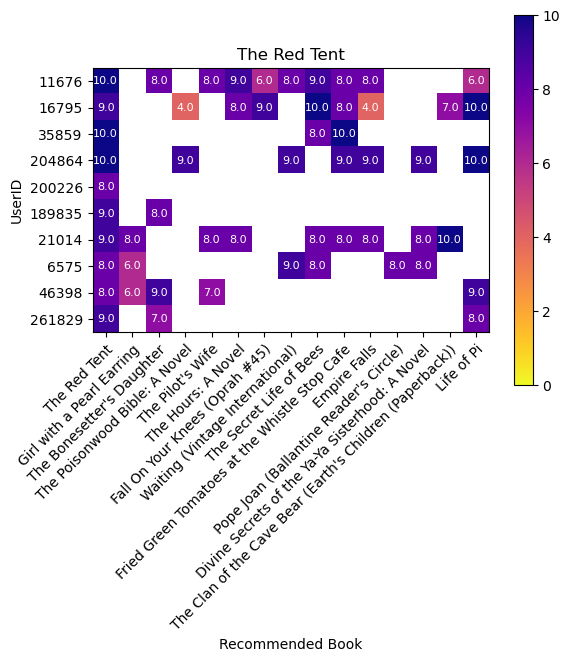

In [140]:
# Creating heatmap of Users that Rated Query book 10, and their ratings for books in the recommended book list
assessment_heatmap(id_list, book_list)

# Issues with Model Construction

Cold-Start Problem:
Model cannot draw recommendations for data that has low backing.  Books that are rated a greater number of times are more likely to be recommended, whereas newer or less popular books will not be recommended.  This could be corrected with matrix factorization, reducing the matrix size therefore reducing matrix sparsity.  A reduced sparsity may result in a better model fit. If book genres were available, and ratings were sorted by genre rather than User, the model may be a better fit.